In [1]:
!make -C .. scenarios statpop

make: Entering directory '/home/martibosch/data-science/lausanne-greening-scenarios'
make: Nothing to be done for 'scenarios'.
make: Nothing to be done for 'statpop'.
make: Leaving directory '/home/martibosch/data-science/lausanne-greening-scenarios'


In [2]:
import tempfile
from os import path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import salem
import seaborn as sns
import swiss_uhi_utils as suhi
import swisslandstats as sls
import xarray as xr
from affine import Affine

from lausanne_greening_scenarios import utils

In [3]:
agglom_extent_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
statpop_filepath = '../data/raw/statpop/statpop-2019.csv'

scenario_ds_filepath = '../data/processed/scenarios.nc'

In [4]:
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
ldf = sls.read_csv(statpop_filepath, x_column='E_KOORD', y_column='N_KOORD')
agglom_ldf = ldf.clip_by_geometry(
    geometry=agglom_extent_gdf.iloc[0]['geometry'],
    geometry_crs=agglom_extent_gdf.crs)
agglom_ldf['total'] = agglom_ldf[[f'B19B{sex}TOT'
                                  for sex in ['M', 'W']]].sum(axis=1)
with tempfile.TemporaryDirectory() as tmp_dir:
    tmp_filepath = path.join(tmp_dir, f'agglom-pop.tif')
    agglom_ldf.to_geotiff(tmp_filepath, 'total')
    agglom_pop_da =  salem.open_xr_dataset(tmp_filepath)['data']

In [5]:
num_change_props = 5
change_props = np.linspace(0, 1, num_change_props)

scenario_T_da = xr.open_dataset(scenario_ds_filepath)['T'].sel(
        change_prop=change_props)
scenario_T_da = xr.concat([
    suhi.align_ds(group_T_da, agglom_pop_da)
    for change_prop, group_T_da in scenario_T_da.groupby('change_prop')
],
                          dim='change_prop')

In [6]:
T_step = 1
T_ser = pd.Series(np.arange(np.floor(scenario_T_da.min().item()),
                            np.ceil(scenario_T_da.max().item()), T_step),
                  name='T')

In [7]:
change_props = scenario_T_da['change_prop']
interactions = scenario_T_da['interaction'].data
scenario_runs = scenario_T_da['scenario_run'].data
pop_count_df = pd.concat([
    pd.DataFrame(
        pd.DataFrame(np.array([
            agglom_pop_da.where(
                scenario_T_da.sel(interaction=interaction,
                                  scenario_run=scenario_run) > T,
                0).sum(dim=['x', 'y']).data for T in T_ser
        ]),
                     index=T_ser,
                     columns=change_props).stack().rename('count')).assign(
                         interaction=interaction, scenario_run=scenario_run)
    for interaction in interactions for scenario_run in scenario_runs
],
                    axis=0).reset_index()
# by default, it is uint16, which will be problematic when computing differences
pop_count_df['count'] = pop_count_df['count'].astype(np.int32)

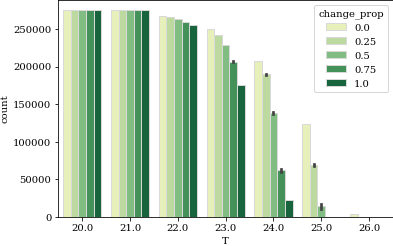

In [8]:
ax = sns.barplot(x='T',
            y='count',
            hue='change_prop',
            data=pop_count_df,
            palette='YlGn')
ax.figure.savefig('../reports/figures/human-exposure.pdf')

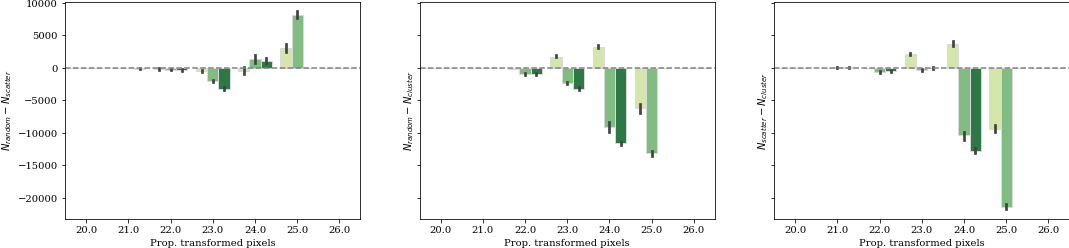

In [9]:
fig = utils.plot_approach_pairwise_comparison(
    pop_count_df[(pop_count_df['change_prop'] > 0)
                 & (pop_count_df['change_prop'] < 1)],
    'T',
    'count',
    'change_prop',
    palette='YlGn')
fig.savefig('../reports/figures/human-exposure-comparison.pdf')